In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [2]:
tf.__version__

'2.13.0'

# Specify each path

In [3]:
dataset = 'model/keypoint_classifier/keypoint.csv'
testset = 'model/keypoint_classifier/keypoint_test.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [4]:
NUM_CLASSES = 10

# Dataset reading


## Giá trị của dữ liệu

In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

## Nhãn của dữ liệu

In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

## Dữ liệu test

In [33]:
X_unseen = np.loadtxt(testset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [34]:
y_unseen = np.loadtxt(testset, delimiter=',', dtype='int32', usecols=(0))

## Chia tập dữ liệu

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [11]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
Total params: 1180 (4.61 KB)
Trainable params: 1180 (4.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [13]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [14]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
72/75 [===========================>..] - ETA: 0s - loss: 2.1691 - accuracy: 0.1937 
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.keras
75/75 [==============================] - 1s 3ms/step - loss: 2.1580 - accuracy: 0.1998 - val_loss: 1.8170 - val_accuracy: 0.4450
Epoch 2/1000
 1/75 [..............................] - ETA: 0s - loss: 1.8590 - accuracy: 0.3672
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.keras
75/75 [==============================] - 0s 1ms/step - loss: 1.6387 - accuracy: 0.4026 - val_loss: 1.2011 - val_accuracy: 0.6795
Epoch 3/1000
 1/75 [..............................] - ETA: 0s - loss: 1.4036 - accuracy: 0.4531
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.keras
75/75 [==============================] - 0s 1ms/step - loss: 1.2039 - accuracy: 0.5487 - val_loss: 0.7802 - val_accuracy: 0.8286
Epoch 4/1000
 1/75 [..............................] - ETA: 0s - loss: 1.0294 - accuracy: 0.60

In [15]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

25/25 [==============================] - 0s 458us/step - loss: 0.0591 - accuracy: 0.9903


In [16]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [17]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))


1/1 [==============================] - 0s 37ms/step
[2.7061445e-11 5.9492411e-11 1.2307293e-37 9.9435061e-01 4.0085913e-05
 1.7523369e-12 6.1421205e-22 3.3245626e-04 1.1145069e-17 5.2768076e-03]
3


In [18]:
# Checking data and label
print(X_test[0])
print(y_test[0])

[ 0.          0.          0.08888889 -0.11555555  0.24444444 -0.17777778
  0.38222224 -0.12888889  0.51111114 -0.05333333  0.50666666 -0.25333333
  0.73333335 -0.28        0.88       -0.27555555  1.         -0.2711111
  0.4888889  -0.13333334  0.63555557 -0.12        0.51555556 -0.12444445
  0.42222223 -0.13777778  0.44       -0.01333333  0.50222224 -0.01333333
  0.38222224 -0.03111111  0.32       -0.05333333  0.37333333  0.08
  0.42666668  0.08        0.3422222   0.04444445  0.29333332  0.00888889]
3


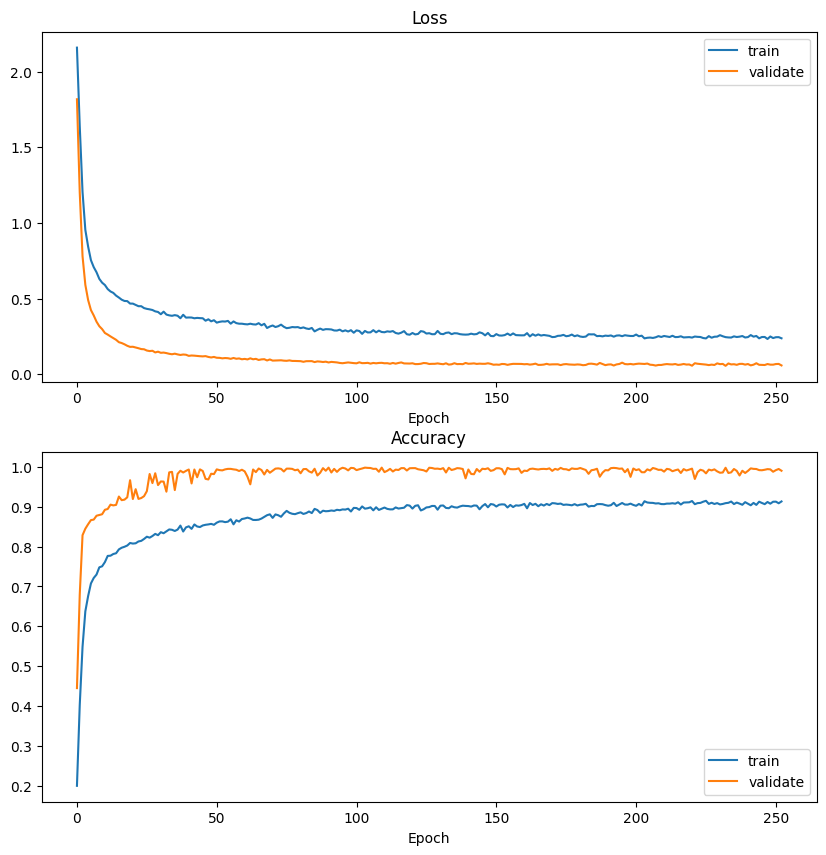

In [19]:
from matplotlib import pyplot
pyplot.subplots(nrows = 2, ncols = 1, figsize=(10, 10))

# Graph to show loss value over time during training (both training set and validating set)
pyplot.subplot(2, 1, 1)
pyplot.title('Loss')
pyplot.xlabel('Epoch')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validate')
pyplot.legend()
# Graph to show accuracy value over time during training (both training set and validating set)
pyplot.subplot(2, 1, 2)
pyplot.title('Accuracy')
pyplot.xlabel('Epoch')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='validate')
pyplot.legend()
pyplot.show()

# Confusion matrix

100/100 [==============================] - 0s 364us/step


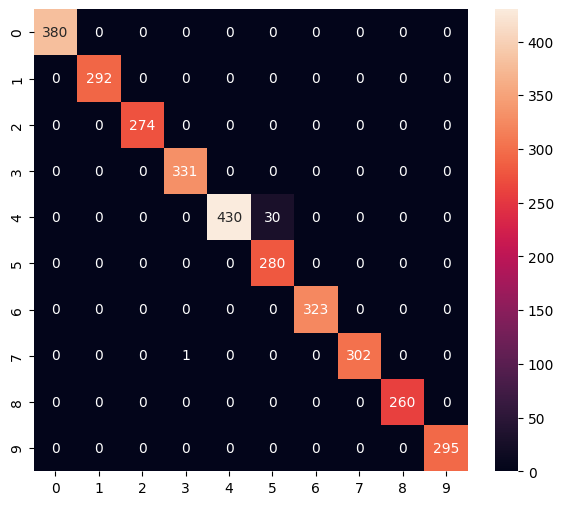

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       380
           1       1.00      1.00      1.00       292
           2       1.00      1.00      1.00       274
           3       1.00      1.00      1.00       331
           4       1.00      0.93      0.97       460
           5       0.90      1.00      0.95       280
           6       1.00      1.00      1.00       323
           7       1.00      1.00      1.00       303
           8       1.00      1.00      1.00       260
           9       1.00      1.00      1.00       295

    accuracy                           0.99      3198
   macro avg       0.99      0.99      0.99      3198
weighted avg       0.99      0.99      0.99      3198



In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)



71/71 [==============================] - 0s 347us/step


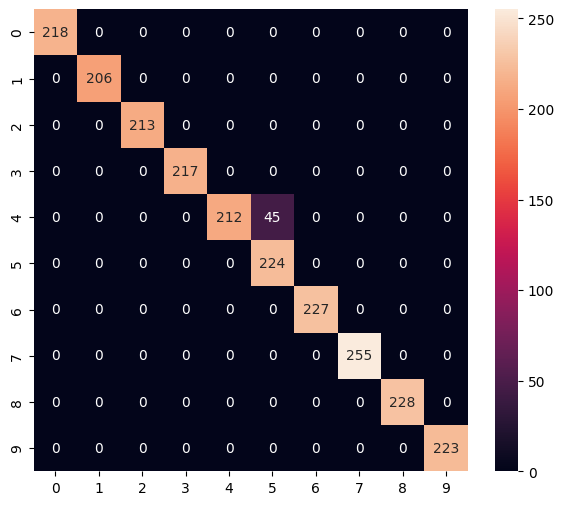

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       218
           1       1.00      1.00      1.00       206
           2       1.00      1.00      1.00       213
           3       1.00      1.00      1.00       217
           4       1.00      0.82      0.90       257
           5       0.83      1.00      0.91       224
           6       1.00      1.00      1.00       227
           7       1.00      1.00      1.00       255
           8       1.00      1.00      1.00       228
           9       1.00      1.00      1.00       223

    accuracy                           0.98      2268
   macro avg       0.98      0.98      0.98      2268
weighted avg       0.98      0.98      0.98      2268



In [35]:
Y_unseen_ = model.predict(X_unseen)
y_unseen_ = np.argmax(Y_unseen_, axis=1)

print_confusion_matrix(y_unseen, y_unseen_)

# Convert to model for Tensorflow-Lite

In [22]:
# Save as a model dedicated to inference
# model.save(model_save_path, include_optimizer=False)
model.save(model_save_path)

In [23]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_ops = [
#                 tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
#                 tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
#             ]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmprxpkmg9c\assets


INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmprxpkmg9c\assets


6808

# Inference test

In [24]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [25]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [26]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [27]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [28]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.7061395e-11 5.9492189e-11 1.2307296e-37 9.9435067e-01 4.0085804e-05
 1.7523336e-12 6.1420740e-22 3.3245535e-04 1.1145069e-17 5.2767983e-03]
3
